## 土壤等级

In [1]:
%pip install xlwt -q
%pip install openpyxl

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
数据预处理

In [3]:
### Start Code Here ###
# 将土壤等级列的标称型数据转换为数值型数据

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openpyxl.workbook import Workbook

filepath = 'test3.xlsx'

data = pd.read_excel(filepath)

display(data)

data.loc[(data[u'土壤等级']=='I'),u'土壤等级']=1
data.loc[(data[u'土壤等级']=='II'),u'土壤等级']=2
data.loc[(data[u'土壤等级']=='III'),u'土壤等级']=3
data.loc[(data[u'土壤等级']=='IV'),u'土壤等级']=4
data.loc[(data[u'土壤等级']=='V'),u'土壤等级']=5
data.loc[(data[u'土壤等级']=='VI'),u'土壤等级']=6
data.loc[(data[u'土壤等级']=='VII'),u'土壤等级']=7

dataT = data.values
data.to_excel('data3.xlsx')
### End Code Here ###

,土壤养分流失度,土壤污染度,土壤等级
0,0.235,0.486,V
1,0.040,0.041,II
2,0.058,0.063,II
3,0.116,0.126,II
4,0.056,0.058,II
...,...,...,...
307,0.041,0.044,I
308,0.048,0.048,I
309,0.086,0.363,IV
310,0.116,0.332,III


运行后打开data3.xls，可以看到将水质等级列表转换为相应的数值：


## 模型构建
本实验我们采用C4.5决策树来进行模型构建。并使用交叉验证方法。

首先需要对数据进行训练集和测试集的划分，本实验以数据集中的80%的数据为训练集，20%为测试集。在上节中数据的变换时，需要将最后一列转换为int型。


In [4]:
### Start Code Here ###
# 划分训练集和测试集
from sklearn.model_selection import train_test_split

# 使用train_test_split函数实现数据集的划分
train,test,train_target,test_target=train_test_split(dataT[:,:2],dataT[:,2],test_size = 0.2)

train_target=train_target.astype(int)
test_target=test_target.astype(int)
### End Code Here ###

In [5]:
# SVC训练 
from sklearn import svm
model = svm.SVC()
model.fit(train, train_target)
display(model.score(test, test_target)) #测试模型打分：只有54%

#重新调整*100
# SVC训练 
from sklearn import svm
model = svm.SVC()
model.fit(train*100, train_target)
display(model.score(test*100, test_target))
display(model.score(train*100, train_target))

0.7936507936507936

0.7936507936507936

0.8755020080321285

接下来，我们开始构建决策树模型，本实验使用sklearn库来实现模型的构建，并将训练结果可视化。

在构建模型时，我们使用了python的learning_curve函数，来得到不同大小的训练集，其交叉验证训练和测试的分数。

ROC AUC Decision Tree:  0.8995983935742973 0.024756682742847286
Best Test Score：0.9699


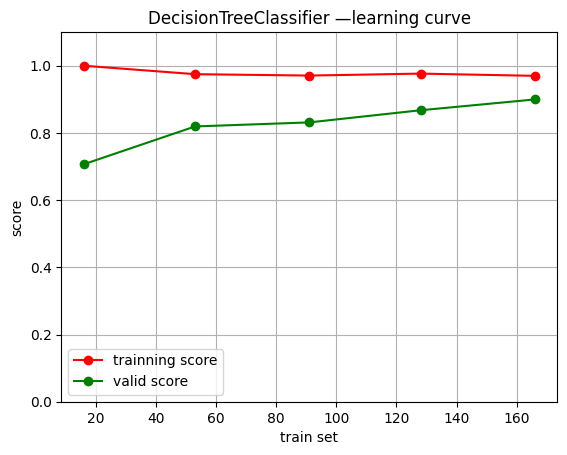

In [6]:
### Start Code Here ###
#构建决策树模型
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

#构建决策树模型clf
clf = DecisionTreeClassifier(max_depth=5)

scores = cross_val_score(clf, train*30, train_target, cv=3) 
print("ROC AUC Decision Tree: ", np.mean(scores), np.std(scores))


from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, X, y, ylim=(0, 1.1), cv=3,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),
                        scoring=None):

    plt.title("%s —learning curve" % type(estimator).__name__)
    plt.ylim(*ylim); plt.grid()
    plt.xlabel("train set")
    plt.ylabel("score")
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="trainning score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",
             label="valid score")
    plt.legend(loc="best")
    print("Best Test Score：{:.4f}".format(train_scores_mean[-1]))

plot_learning_curve(clf, train, train_target) 

#clf.fit(train,train_target)
### End Code Here ###


运行后，可以看到训练集的大小与交叉验证分数成正比.
## 模型评价

我们计算不同深度训练集和测试集交叉验证得分。通过图表来选取最合适的深度值。

Best test score: 0.8876


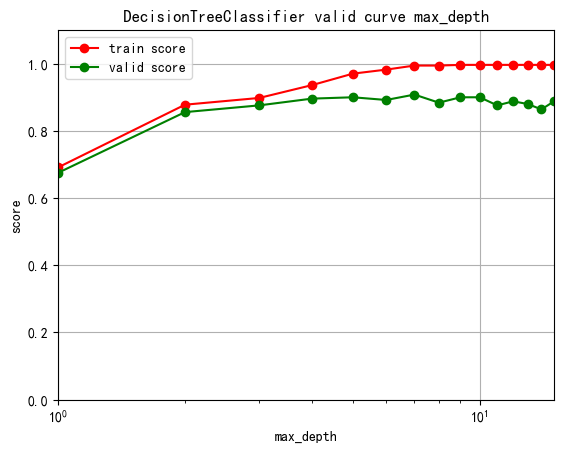

In [7]:
### Start Code Here ###

from sklearn.model_selection import validation_curve

#利用validation_curve计算不同深度训练集和测试集交叉验证得分
def plot_validation_curve(estimator, X, y, param_name, param_range,
                          ylim=(0, 1.1), cv=3, n_jobs=1, scoring=None):
    plt.rcParams['font.sans-serif']=['SimHei']
    estimator_name = type(estimator).__name__
    plt.title(" %s valid curve %s "
              % (estimator_name,param_name))
    plt.ylim(*ylim); plt.grid()
    plt.xlim(min(param_range), max(param_range))
    plt.xlabel(param_name)
    plt.ylabel("score")

    #通过调用validation_curve来计算训练集的得分cores和验证集的得分test_scores
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, n_jobs=n_jobs, scoring=scoring)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.semilogx(param_range, train_scores_mean, 'o-', color="r",
                 label="train score")
    plt.semilogx(param_range, test_scores_mean, 'o-', color="g",
                 label="valid score")
    plt.legend(loc="best")
    print("Best test score: {:.4f}".format(test_scores_mean[-1]))

clf = DecisionTreeClassifier(max_depth=8)
param_name = 'max_depth'
param_range = [1, 2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15]

plot_validation_curve(clf, train*30, train_target,
                      param_name, param_range)
### End Code Here ###